# Regression: II

*S. R. Taylor (2025)*

This lecture and notebook are based on the "Regression" and "Regression2" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Andy Connolly, and Ivezic et al. Chapter 8, and Andy Connolly's [blog](http://connolly.github.io/introAstroML/blog/regression.html).

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 8.

---

## Contents
* [Regularization](#one)
* [Non-linear regression](#two)
* [Gaussian process regression (GPR)](#three)
* [Uncertainties all round](#four)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Regularization <a class="anchor" id="one"></a>

We have to be careful when performing regression because if we progressively increase the complexity of the model, then we reach a regime where we are overfitting the data (i.e. there are too many degrees of freedom in the model). This causes high variance in the model, resulting in poor performance in cross-validation and testing datasets.

Let's look at an example using `Polynomial Regression`. We'll fit some data with successively higher-degree polynomials.

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

/home/js3/miniconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


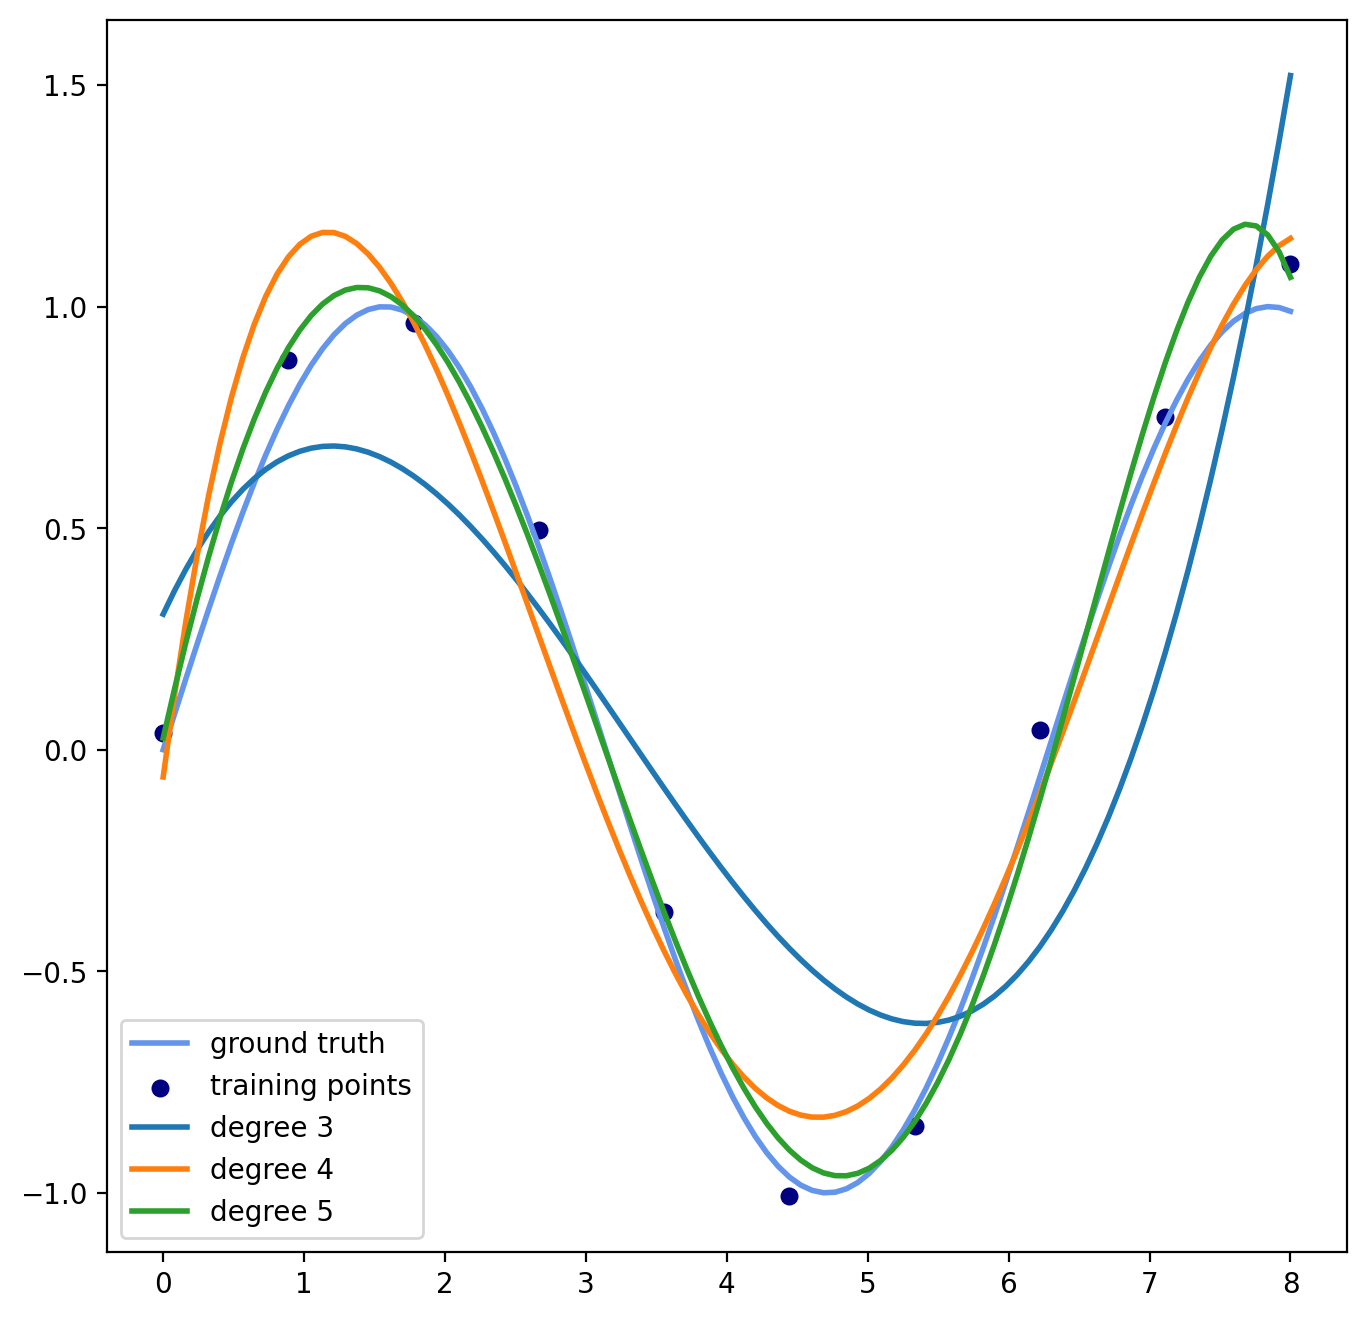

In [2]:
from astroML.linear_model import PolynomialRegression

degrees = [3, 4, 5]

def f(x):
    """ function to approximate by polynomial interpolation """
    return np.sin(x)

# generate points used to plot
x_plot = np.linspace(0, 8, 100)

# generate points and keep a subset of them
x = np.linspace(0, 8, 10)
y = f(x) + 0.25 * (np.random.random(len(x)) - 0.5)

# create matrix versions of these arrays
X = x[:, None]
X_plot = x_plot[:, None]

colors = ['C0', 'C1', 'C2']
lw = 2
plt.figure(figsize=(8,8))
plt.plot(x_plot, f(x_plot), 
         color='cornflowerblue', 
         linewidth=lw, label="ground truth")
plt.scatter(x, y, color='navy', s=30, 
            marker='o', label="training points")

for count, degree in enumerate(degrees):
    poly = PolynomialRegression(degree)
    poly.fit(X,y)
    y_plot = poly.predict(X_plot)

    plt.plot(x_plot, y_plot, color=colors[count], 
             linewidth=lw, label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

This is fit with `degree = 3, 4, 5`. <font color='red'>What happens if you make the degree be equal to $\sim N_{\rm points}$ and higher? Try it.</font>

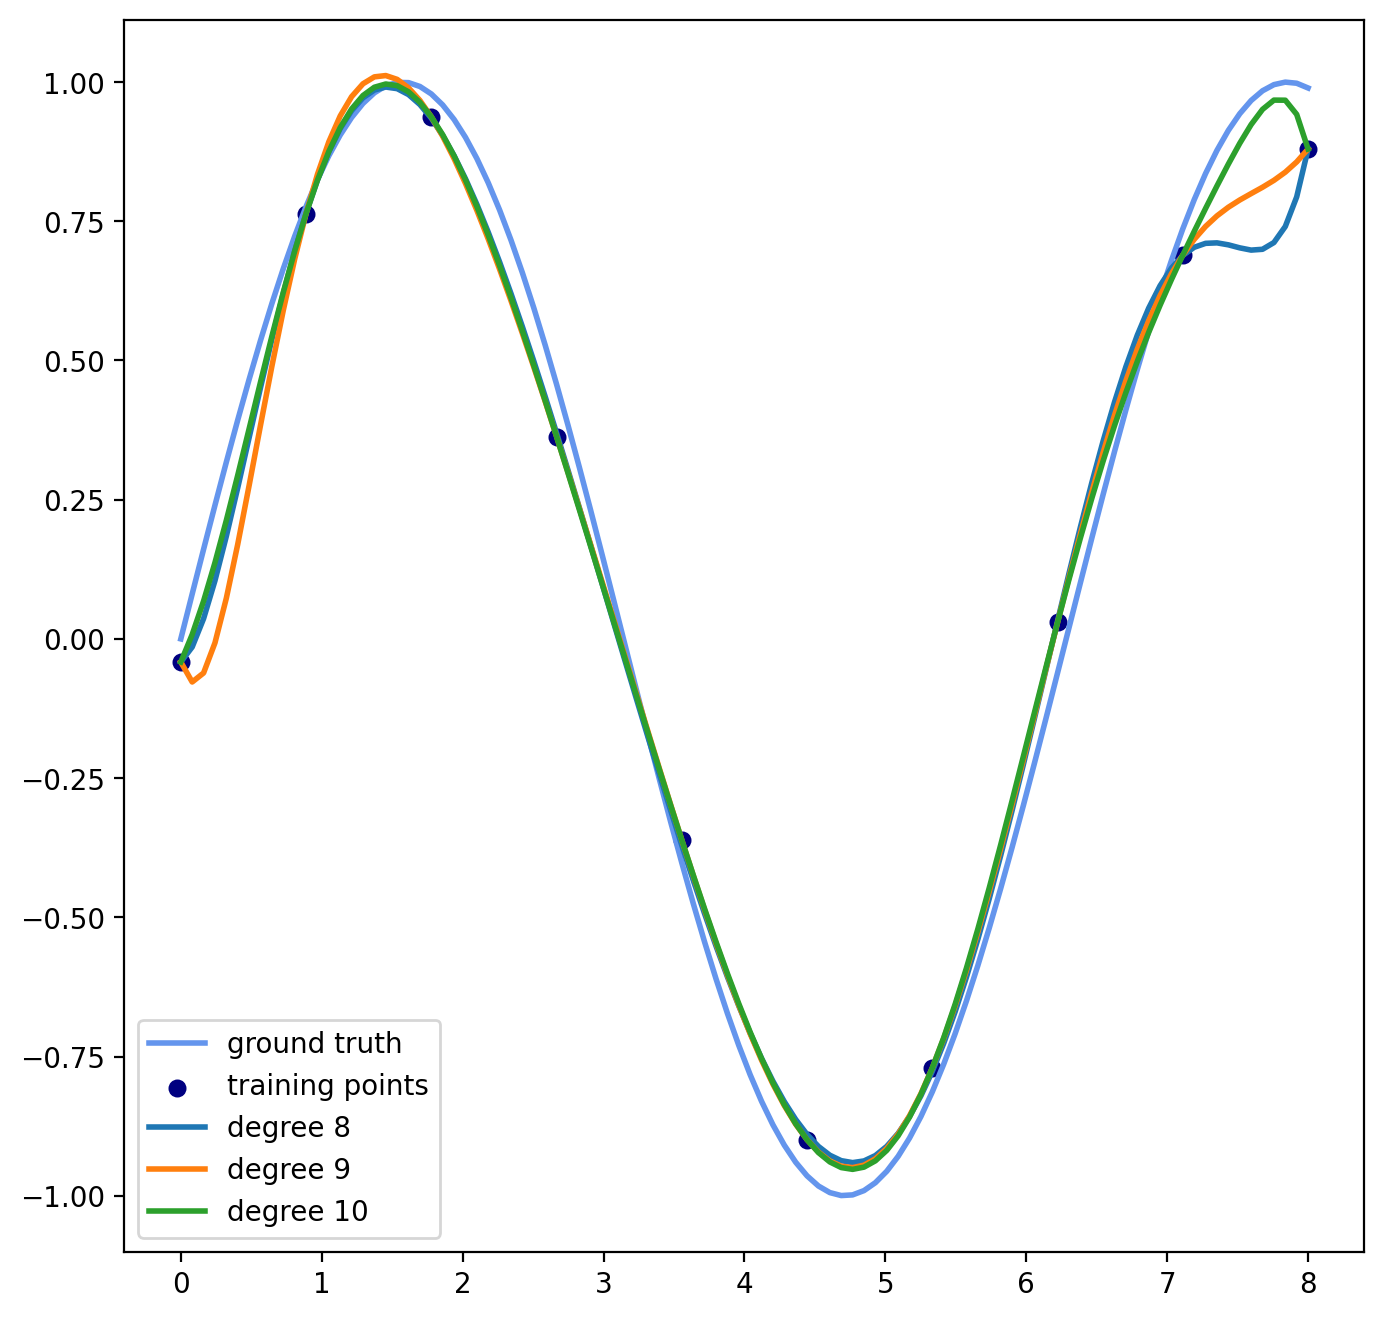

In [8]:
from astroML.linear_model import PolynomialRegression

degrees = [8,9,10]

def f(x):
    """ function to approximate by polynomial interpolation """
    return np.sin(x)

# generate points used to plot
x_plot = np.linspace(0, 8, 100)

# generate points and keep a subset of them
x = np.linspace(0, 8, 10)
y = f(x) + 0.25 * (np.random.random(len(x)) - 0.5)

# create matrix versions of these arrays
X = x[:, None]
X_plot = x_plot[:, None]

colors = ['C0', 'C1', 'C2']
lw = 2
plt.figure(figsize=(8,8))
plt.plot(x_plot, f(x_plot), 
         color='cornflowerblue', 
         linewidth=lw, label="ground truth")
plt.scatter(x, y, color='navy', s=30, 
            marker='o', label="training points")

for count, degree in enumerate(degrees):
    poly = PolynomialRegression(degree)
    poly.fit(X,y)
    y_plot = poly.predict(X_plot)

    plt.plot(x_plot, y_plot, color=colors[count], 
             linewidth=lw, label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

<font color="blue"> You can see at the final set of points that the regression begins to break down (this is really bad if you set the degree to 20 but it makes the others hard to see) </font>

In that case we are clearly overfitting the data. For me it was visible in the space between the penultimate and final data point, where the model had huge variance and would have performed terribly in cross-validation.

For cases where we are concerned with overfitting, instead of making our log-likelihood be related to just the sum of the squares: 

$$(Y - M\theta)^T C^{-1} (Y - M\theta),$$

we can apply additional constraints (usually of **smoothness**, **number of coefficients**, **size of coefficients**):

$$(Y - M \theta)^T C^{-1} (Y- M \theta) + \lambda\, \theta^T\theta,$$

with **$\lambda$ as the "regularization parameter"**. **NOTE--** *This corrects and clarifies some of the math notation in Ivezic 8.3.*

Upon maximizing the modified log-likelihood (or minimizing the modified relationship in the previous equation), this leads to a solution for the parameters of the model

$$\hat\theta = (M^T C^{-1} M + \lambda I)^{-1} (M^T C^{-1} Y)$$

with $I$ the identity matrix.

From the **Bayesian perspective** this is trivial. We have just applied a prior constraint on the parameters of our model that help control the posterior distribution of parameters. In this scenario, our prior is

$$p(\theta | I ) \propto \exp{\left(\frac{-\lambda\, \theta^T\theta}{2}\right)}$$

which, when multiplied by the data likelihood for regression, gives the same answer for the maximum of the posterior probability as described above.

***Reguarlization tries to get us into the Goldilocks regime where we have a [balanced solution](https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db) to the regression between underfitting and overfitting***.

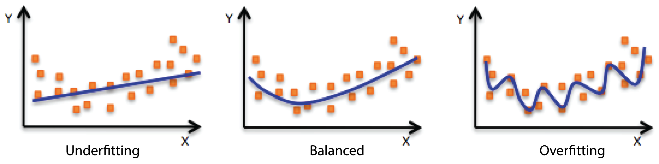

### Ridge regression 

Such a Gaussian prior on regression coefficients corresponds to **[Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization)** (or ***Tikhonov Regularization***), which penalizes the regression coefficients according to

$$ \theta^T \theta \equiv \sum_i \theta_i^2 < s.$$

That is **the sum of the squares of the regression coefficients are restricted to be less than some tolerance value**, $s$. We'll come back to exactly what $s$ is in a minute. Doing this supresses large regression coefficients and limits the variance of the model---at the cost of increased bias (i.e. the solution may not pass as closely through all data points).

The following figure illustrates the interaction of the prior and the posterior without the prior. In the left panel, the ridge prior drags the solution to smaller values of the regression coefficients than they would otherwise have been with an uninformative prior:
![Ivezic, Figure 8.3](http://www.astroml.org/_images/fig_lasso_ridge_1.png)

`Scikit-Learn`'s [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is their implementation of ridge regression, while `AstroML` implements Ridge Regression as follows:

In [9]:
from sklearn.linear_model import Ridge

X = np.random.random((100,10))
y = np.dot(X, np.random.random(10))
model = Ridge(alpha=0.05) # alpha here is lambda in the book
model.fit(X,y)
y_pred = model.predict(X)

The following example compares *Gaussian Basis Regression* with and without the constraints from *Ridge Regression*. It uses **$100$ evenly spaced Gauassians, which we can see strongly overfits the problem and has very large coefficient values, until a constraint is imposed**.

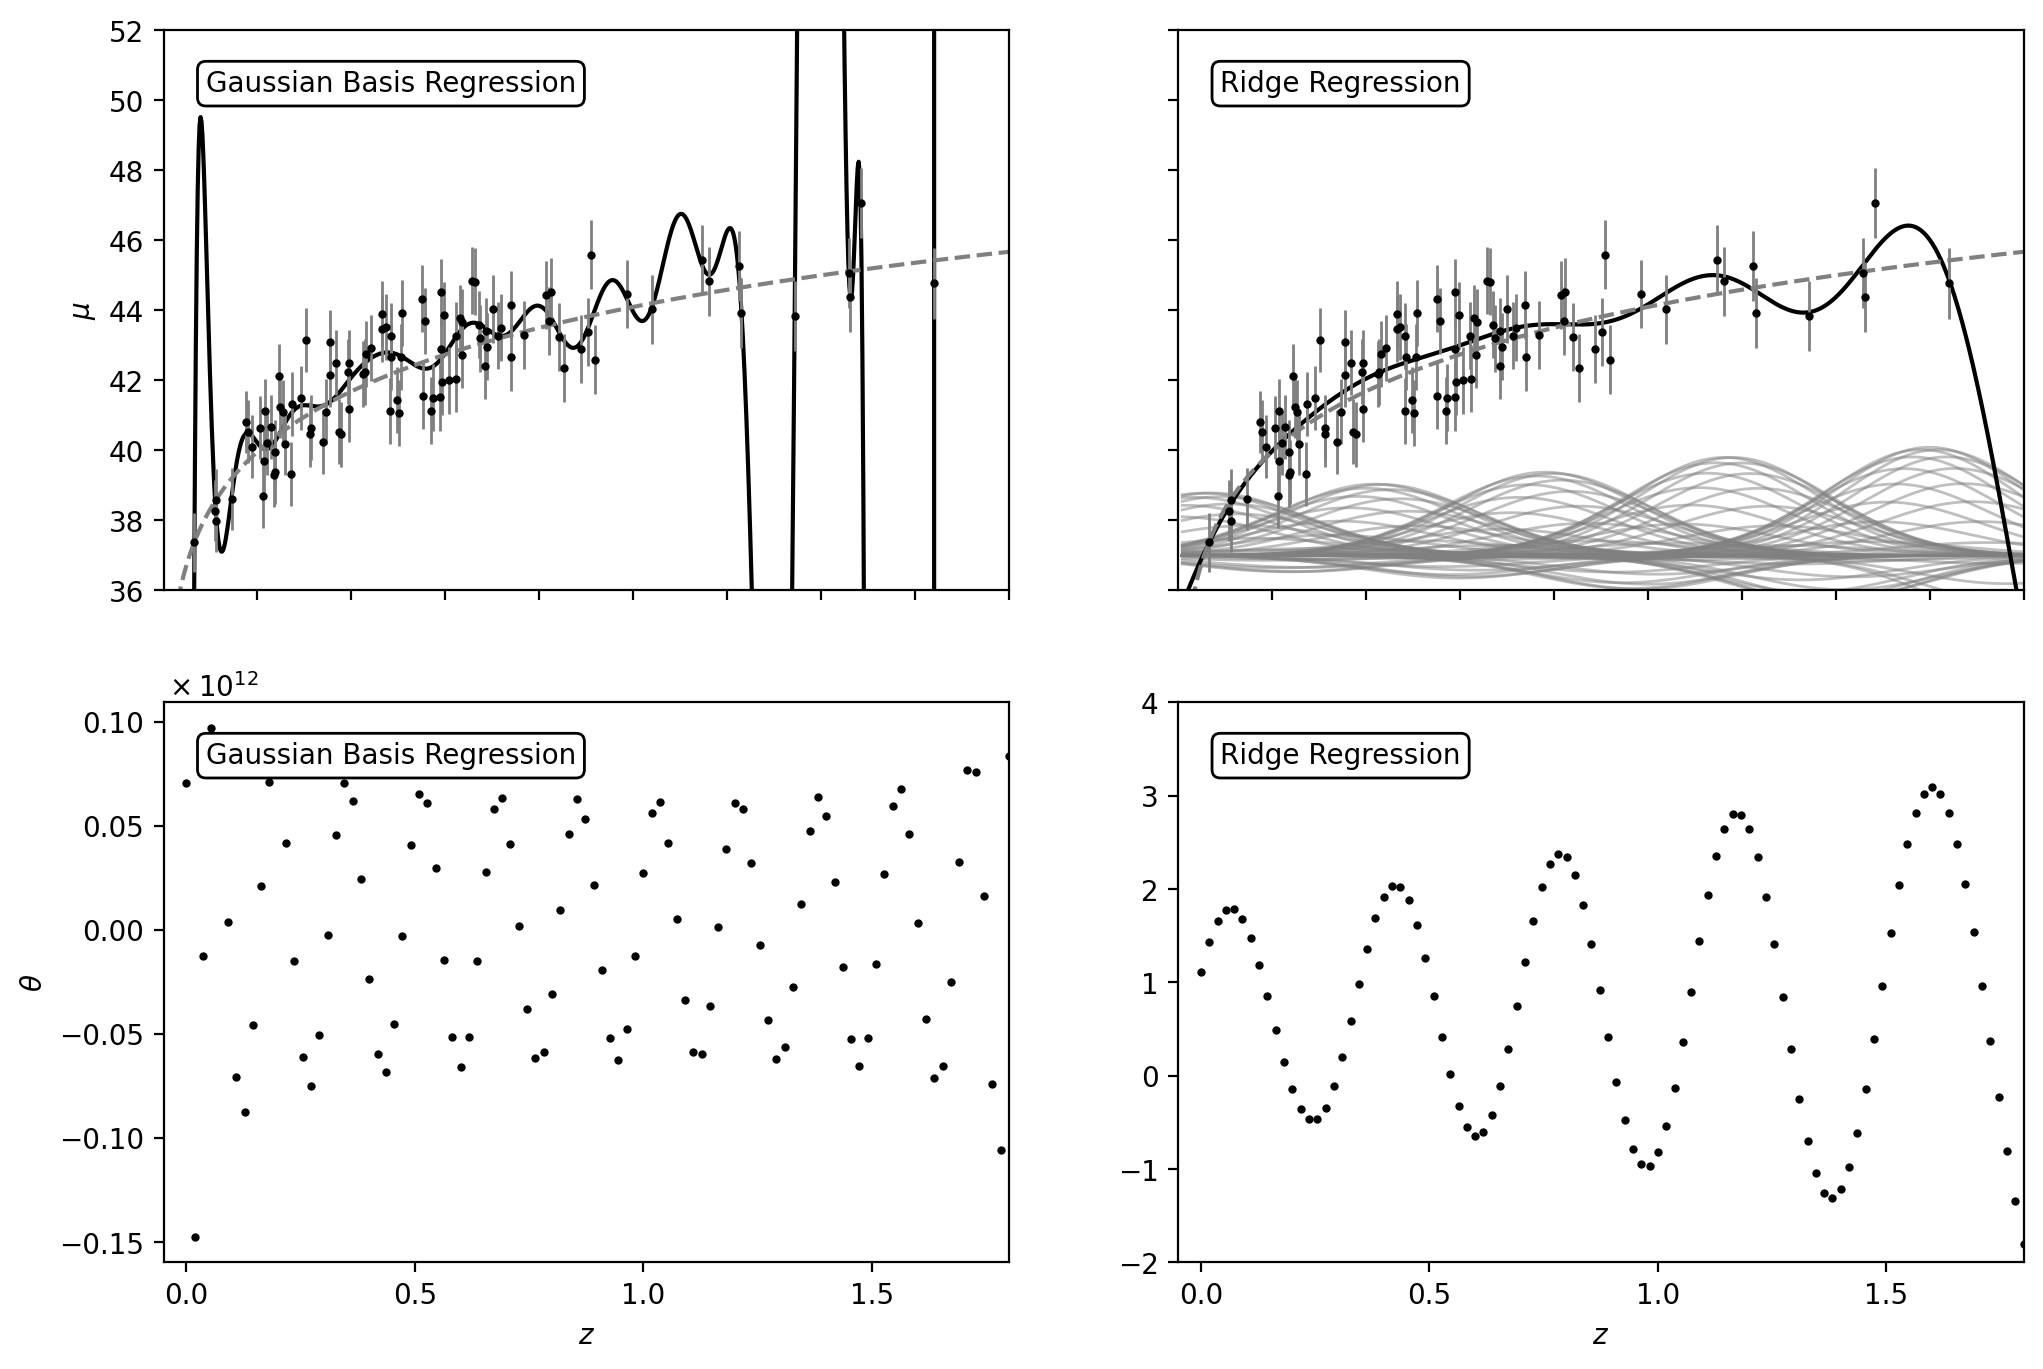

In [10]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import lognorm
from sklearn.linear_model import LinearRegression, Ridge
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# generate data
np.random.seed(0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu = cosmo.distmod(z)

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, None], 
                   centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 8))

classifier = [LinearRegression, Ridge]
kwargs = [dict(), dict(alpha=0.005)]
labels = ['Gaussian Basis Regression', 'Ridge Regression']

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], 
                                     centers, widths))

    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], 
                                         centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, 
                fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', 
                      ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', 
                      ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

### Least Absolute Shrinkage and Selection (LASSO) regularization

An alternative to Ridge Regression is **LASSO**, which implies the following contraint:

$$(Y - M \theta)^T(Y- M \theta) + \lambda \sum_i|\theta_i|.$$

This is equivalent to least-squares minimization with the restriction that

$$ \sum_i|\theta_i| < s,$$

that is, the **penalty is now on the sum of the absolute values of the regression coefficients**, which is also illustrated in Ivezic, Figure 8.3 as shown in the right panel above.

It not only weights the regression coefficients, it also **imposes sparsity on the regression
model** (i.e. the penalty preferentially selects regions of likelihood space that coincide with one of the vertices within the region defined by the regularization).

***This has the effect of setting one (or more) of the model attributes to zero.***  

`Scikit-Learn`'s **[`LASSO`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)** is implemented as follows:

In [37]:
from sklearn.linear_model import Lasso

XX = np.random.random((100,10))
yy = np.dot(XX, np.random.random(10))
model = Lasso(alpha = 0.05)
model.fit(XX,yy)
y_pred = model.predict(XX)

Below I have copied the Ridge regression cell from above.  <font color='red'>Modify the three lines of code needed to replace Ridge regression with Lasso regression. Look for #!!!! for these lines. Then experiment with different values of the regularization parameter.</font>

**N.B.  $\lambda$ in the book is related to $\alpha$ in these examples.**

/home/js3/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/js3/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/js3/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.241e+01, tolerance: 3.554e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = c

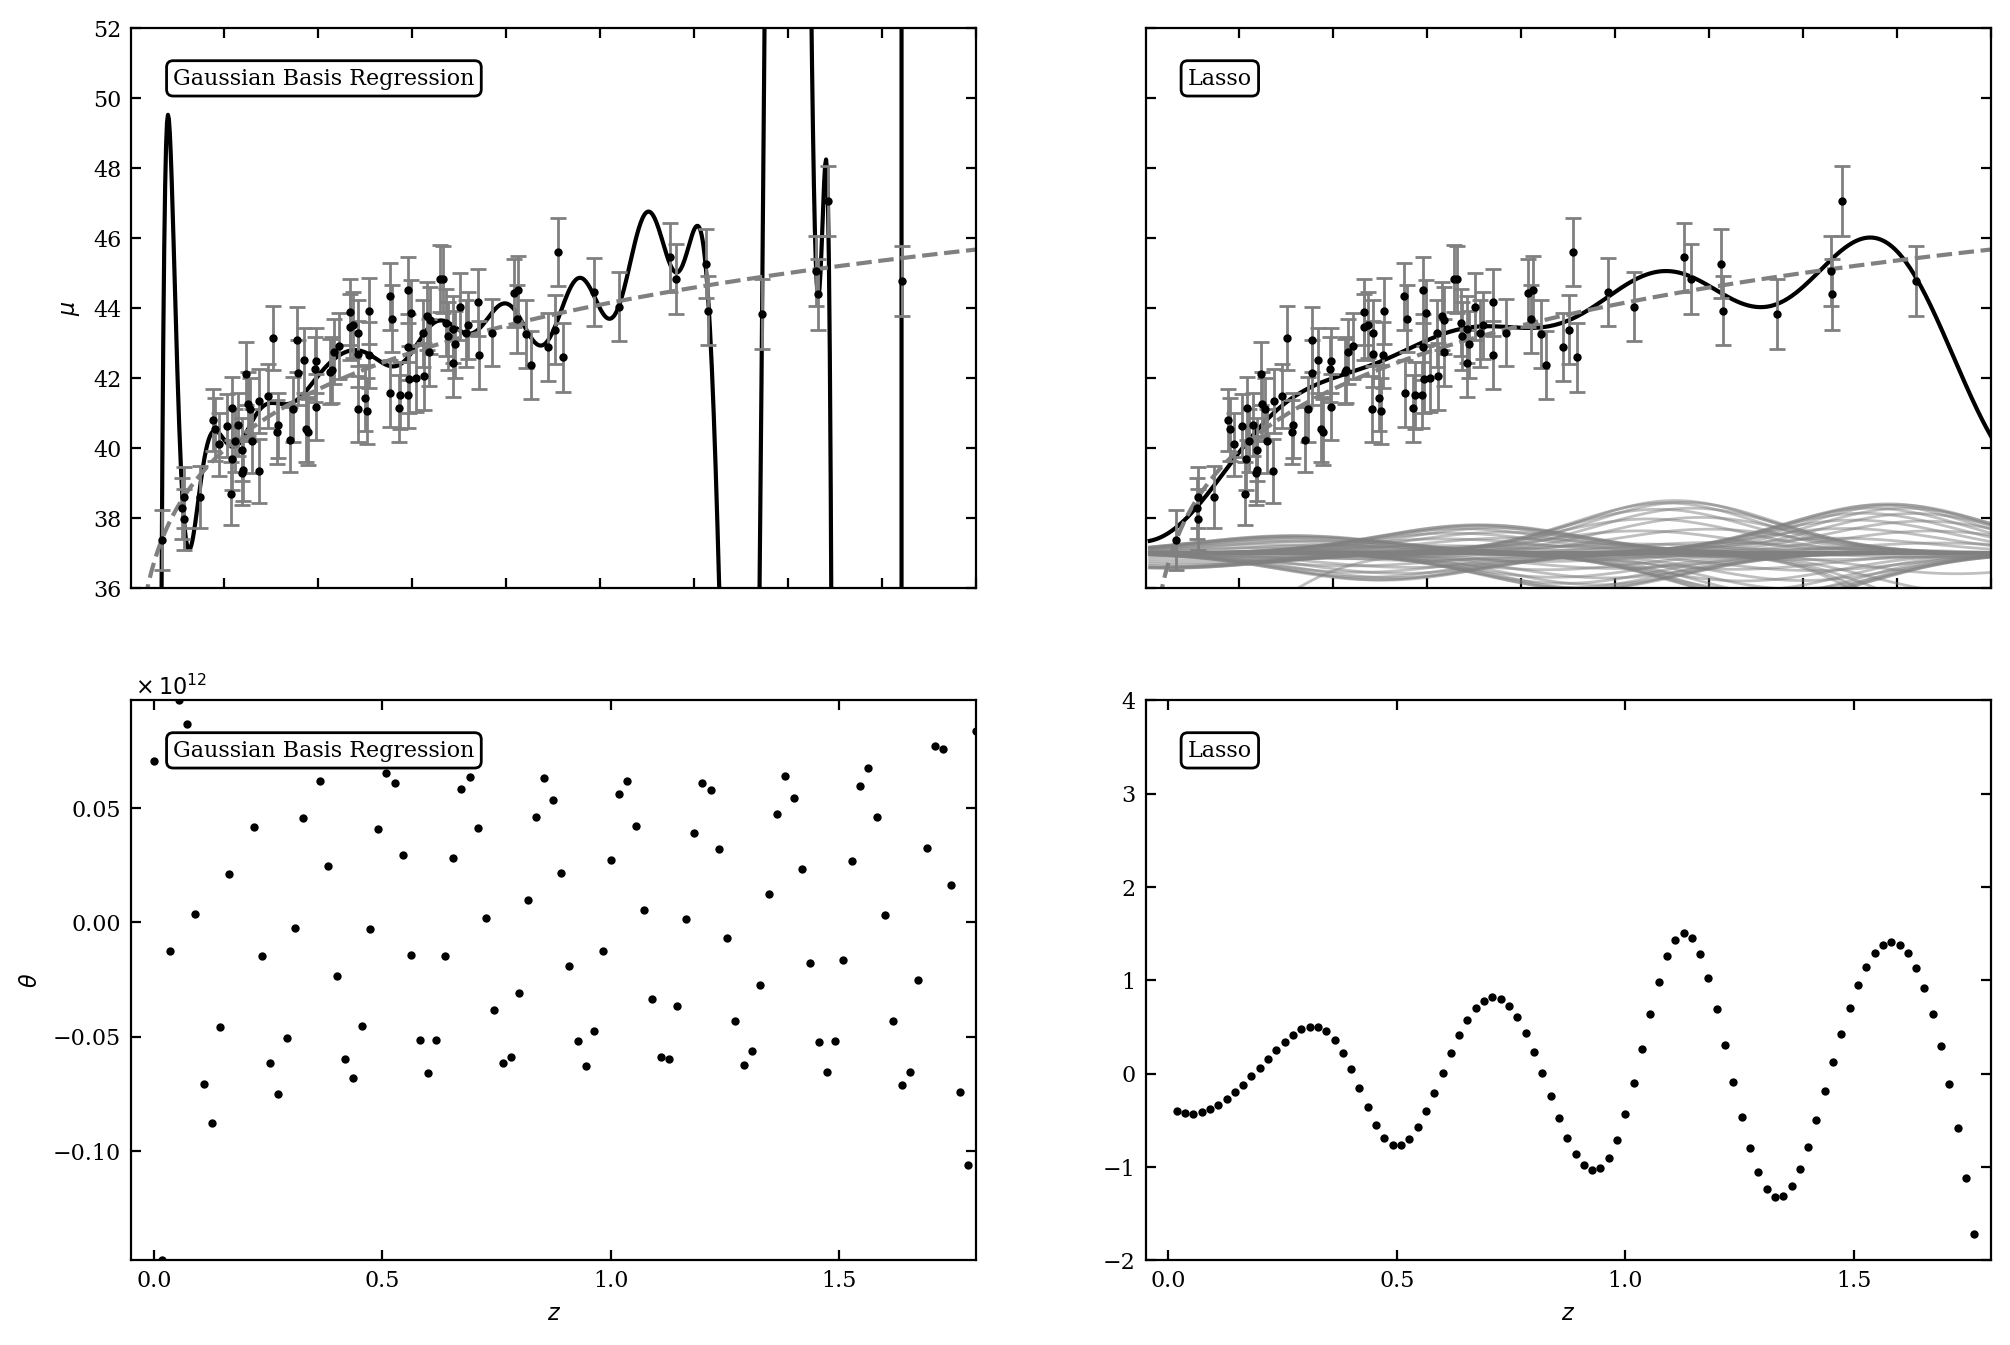

In [39]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import lognorm
from sklearn.linear_model import LinearRegression, Lasso #!!!!

#from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# generate data
np.random.seed(0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu = cosmo.distmod(z)

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, None], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 8))

classifier = [LinearRegression, Lasso] #!!!!
kwargs = [dict(), dict(alpha=0)]
labels = ['Gaussian Basis Regression', 'Lasso'] #!!!!

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

<font color='red'>Did you try `alpha=0`? If not, go ahead and do that.</font>

Are you totally confused?  Don't worry, it is much simpler than it seems. [Hastie et al.](http://statweb.stanford.edu/~tibs/ElemStatLearn/index.html) is helpful in clarifying all this. 

They write the constraint term as 

$$\lambda \sum_{i=1} |\theta_i|^q,$$

which allows us to see that **Ridge regression corresponds to $q=2$**, while **LASSO regression corresponds to $q=1$**.  So, they are really the same thing: Bayesian estimates with different priors. The wildly different names are just a nuisance. Hastie et al. shows what contours of the constant constraint term look like for different $q$.

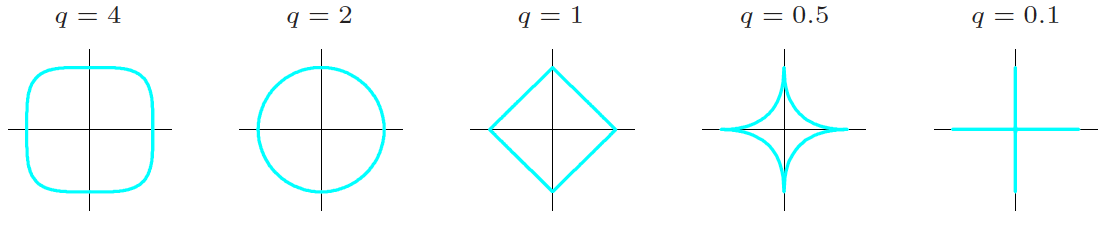

With that in mind, now let's see if we can understand what is going on in Ivezic, Figure 8.3.  We now have

$$ \lambda \sum_{i=1} |\theta_i|^q < s.$$

Think of $s$ as a normalized distance where $s=1$ corresponds to there being no constraint on $\theta_i$. Requiring $s<1$ limits the magnitude of $\theta_i$. So, in this figure
![Ivezic, Figure 8.3](http://www.astroml.org/_images/fig_lasso_ridge_1.png)
$s=1$ would make the circle/diamond big enough to include what they call $\theta_{\rm normal}$.   

Shrinking $s$ has the effect of adding a prior that moves the best-fit parameters to the intersection of the two sets of contours. **The difference between Ridge and LASSO is just the shape of the constraint region.** For LASSO, the shape is such that some of the parameters may end up being 0, which is super beneficial.

One drawback of LASSO is that it does not have a closed-form analytic regression like Ridge does-- the problem must be solved numerically.

### How do we choose $\lambda$?

We use cross-validation, just as we discussed last time. In fact...`Scikit-Learn` has versions of Ridge and LASSO regression that do this automatically for you-- see [`RidgeCV`](https://scikit-learn.org/stable/modules/linear_model.html#setting-the-regularization-parameter-leave-one-out-cross-validation) and [`LassoCV`](https://scikit-learn.org/stable/modules/linear_model.html#using-cross-validation).

---

Let's practice all this using the [California Housing Data](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html).  

As a reminder, this data set contains 8 attributes that can be used to predict the price of houses in California.  Because the attributes (columns of $X$) are inhomogenous, some may be more relevant than others. So LASSO might be a good thing to try in such situations.

In [17]:
#Execute this cell to read in the data
#Also identify the index of the "Number of Rooms" attribute
import numpy as np
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
print(california.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Start by looking at just how the median income in the area predicts the price.

In [20]:
IncIndex = california.feature_names.index("MedInc")
print(IncIndex)

X_Inc = california.data[:,IncIndex][:,None]
y = california.target

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_Inc, y)
print(reg.coef_, reg.intercept_)

0
[0.41793849] 0.45085576703267893


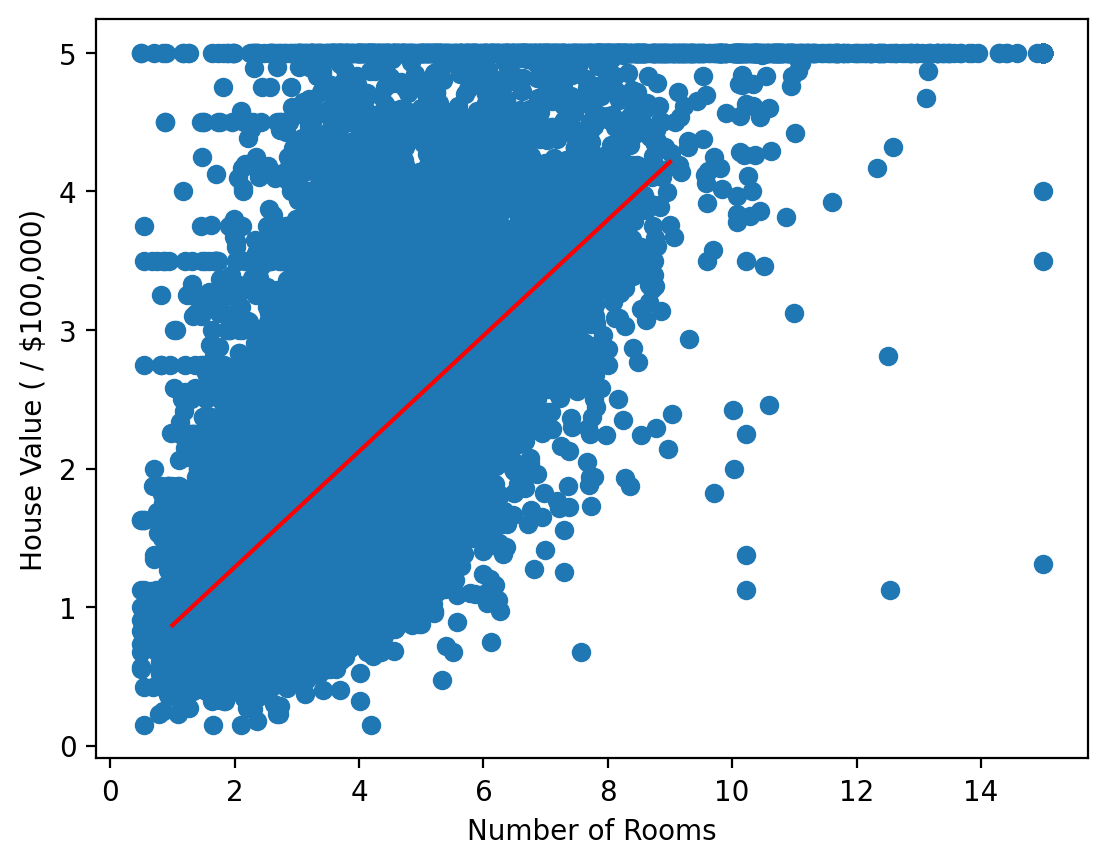

In [21]:
import matplotlib.pyplot as plt
plt.scatter(X_Inc,y)
plt.xlabel("Number of Rooms")
plt.ylabel("House Value ( / $100,000)")

Xgrid = np.linspace(1,9,9)
ypred = reg.intercept_ + Xgrid*reg.coef_[0]
plt.plot(Xgrid,ypred, c='r')
#plt.xlim(3.5,9)
#plt.ylim(0,52)
plt.show()

- Now use **all attributes**, first with `LinearRegression`.  
- Then with `LinearRegression again`, but with the data scaled using `StandardScaler` from `sklearn.preprocessing` (since the features are very heterogeneous, i.e. they vary over different ranges and scales). 
- Then fit the scaled data agin with LASSO to see which features aren't that important. Experiment with the $\alpha$ value. 
- We'll plot the coefficients of each.

<font color='red'>Complete the following cell.</font>

In [45]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = california.data
y = california.target

scaler = StandardScaler()

Xscaled = scaler.fit_transform(X)

linreg = LinearRegression().fit(X,y)
linreg_scaled = LinearRegression().fit(Xscaled,y)
lasso_scaled = Lasso(alpha=0.05).fit(Xscaled,y)

print(linreg.coef_, linreg.intercept_)
print(linreg_scaled.coef_, linreg_scaled.intercept_)
print(lasso_scaled.coef_, lasso_scaled.intercept_)

[ 4.36693293e-01  9.43577803e-03 -1.07322041e-01  6.45065694e-01
 -3.97638942e-06 -3.78654265e-03 -4.21314378e-01 -4.34513755e-01] -36.94192020718448
[ 0.8296193   0.11875165 -0.26552688  0.30569623 -0.004503   -0.03932627
 -0.89988565 -0.870541  ] 2.0685581690891386
[ 0.73654297  0.13900648 -0.          0.          0.         -0.
 -0.25950684 -0.21678118] 2.068558169089145


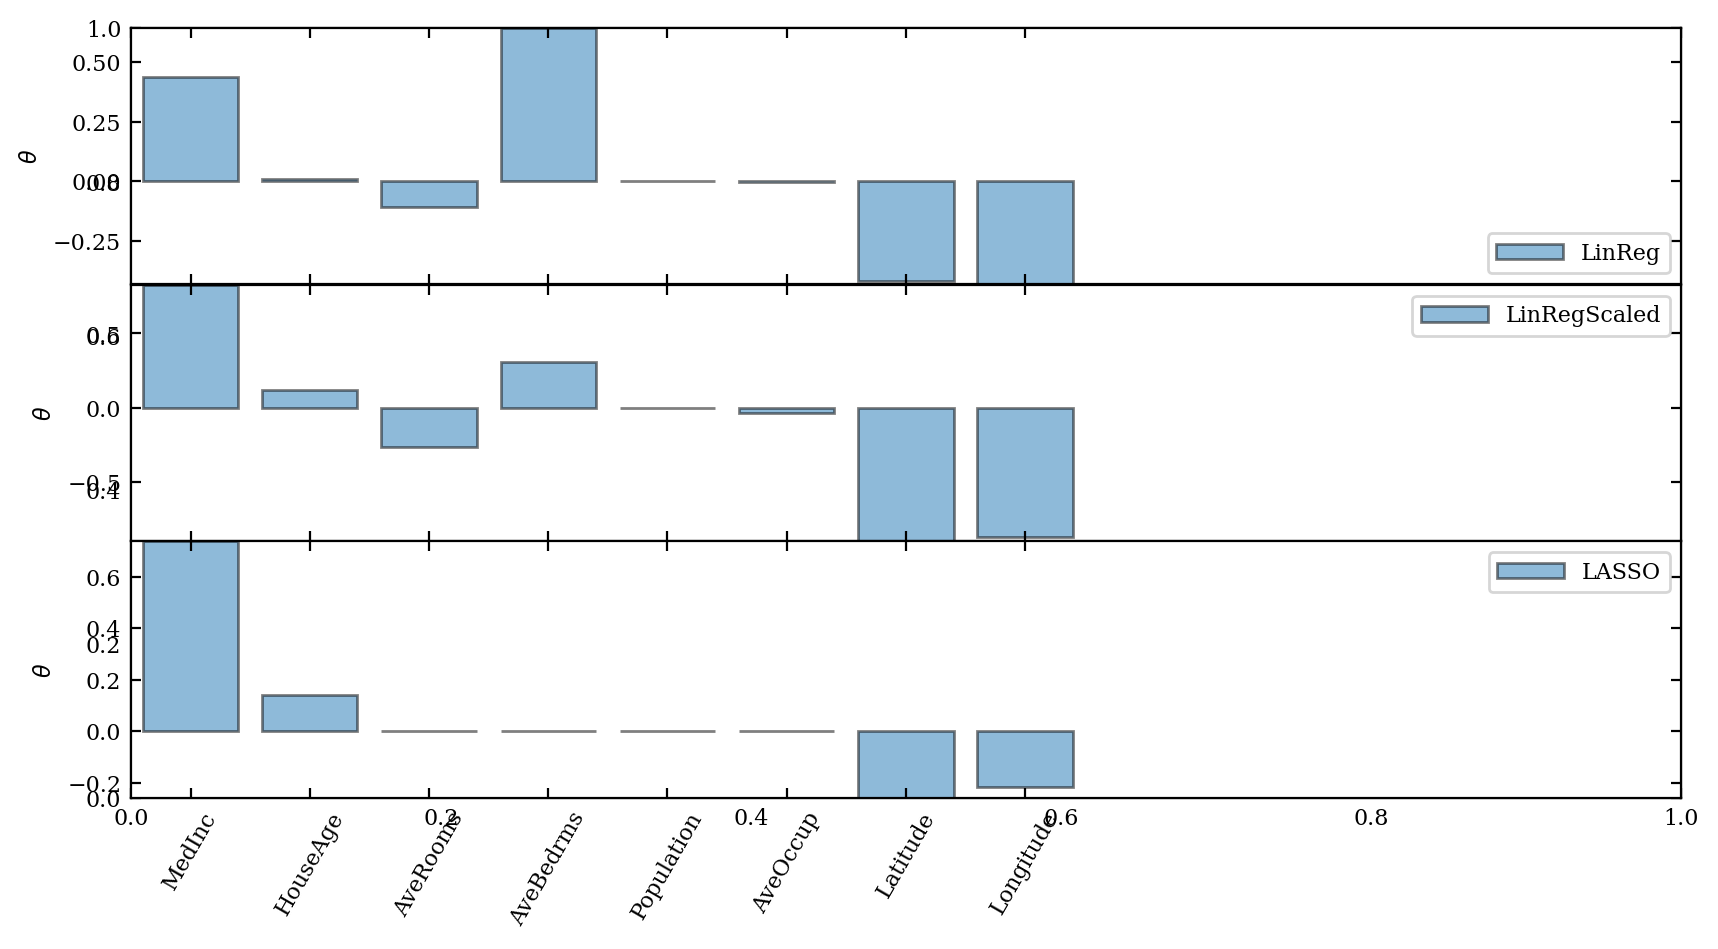

In [46]:
fig, ax = plt.subplots(figsize=(10, 5)) 
plt.subplots_adjust(hspace=0.001)

x_pos = np.arange(len(california.feature_names))

for i in range(3):
    # plot theta
    ax = plt.subplot(311 + i)
    ax.set_ylabel(r'$\theta$')

    ax.set_xticks(x_pos)
    if i == 2:
        ax.set_xticklabels(california.feature_names, 
                           rotation=60)     
    else: 
        ax.set_xticklabels([])
    
    ax.set_xlim(-0.5, 12.5)
 
    if i == 0:
        ax.bar(x_pos, linreg.coef_, 
               alpha=0.5, label="LinReg")
        plt.legend(loc=4)
        
    elif i == 1:
        ax.bar(x_pos, linreg_scaled.coef_, 
               alpha=0.5, label="LinRegScaled")
        plt.legend(loc=1)
        
    elif i == 2:
        ax.bar(x_pos, lasso_scaled.coef_, 
               alpha=0.5, label="LASSO")
        plt.legend()

plt.show()

<font color="blue"> Population and Average Occupancy seem to be the parameters across the three models that don't matter in terms of the fit </font>

You should probably scale the data first to get all attributes on equal scale footing. 

<font color='red'>Which attribute coefficients are driven toward zero the most, and thus which attributes don't matter in determining the housing prices?</font>

Let's try `LassoCV` below:

In [27]:
from sklearn.linear_model import LassoCV

lasso_scaled_cv = LassoCV(cv=5).fit(Xscaled,y)

print(lasso_scaled_cv.coef_, lasso_scaled_cv.intercept_)
print(lasso_scaled_cv.alpha_)

[ 0.81616436  0.1211406  -0.23007984  0.27029251 -0.0009902  -0.0369377
 -0.8718173  -0.84084069] 2.068558169089139
0.0025999572889688115


---

Up to now we have been fitting using ***linear models***, i.e. where the model depends linearly on the regression coefficients. Before moving on to ***non-linear models***, we'll look at **local linear fitting**. Kernel Regression (or Nadaraya-Watson) was one such method.  

### Locally Linear Regression (LOWESS or LOESS)

In **[Local Linear Regression](https://en.wikipedia.org/wiki/Local_regression)** we assume that the regression function at any point can be approximated by a [Taylor series expansion](https://www.mathsisfun.com/algebra/taylor-series.html). If we truncated at the first term (i.e., a locally constant solution) we recover Kernel Regression.

LLR is similar to Kernel regression, except that we fit the local regression to the weighted points by finding a weighting function $w(x)$ that minimizes

$$\sum_{i=1}^N  K\left(\frac{||x-x_i||}{h}\right) \left( y_i - w(x) \, x_i \right)^2.$$

One version of this called **LOWESS (locally weighted scatter plot smoothing)** uses the "tricubic" Kernel:

$$K(x_i,x) = \left ( 1 - \left ( \frac{|x - x_i |}h{}\right )^3 \right )^3.$$

However, the book doesn't delve into this (or LOESS, which might stand for LOcal regrESSion) and it doesn't appear that this is implemented in either `AstroML` or `Scikit-Learn`. However, after scouting around, it does appear to be implemented in an unofficial Scikit-Learn extension called [`Scikit-Lego`](https://scikit-lego.readthedocs.io/en/latest/index.html)-- see https://scikit-lego.readthedocs.io/en/latest/linear-models.html#LOWESS. But we're not going to explore this here; we'll be moving on--just realize that there algorithms that are intermediate between linear and nonlinear.

## Non-linear Regression <a class="anchor" id="two"></a>

Often we can make our non-linear data linear (e.g., if your $y$ values increase exponentially with $x$, by taking the log), but that has its own set of complications (e.g., asymmetric error bars). So we should also consider **non-linear regression, i.e., where the model depends non-linearly on the regression parameters.** 

If we know the theoretical form of the model, then one option is to use MCMC techniques to sample the parameter space and find the optimal model parameters. We've seen that technique *ad nauseum*, and you know most of the tricks to do this well.

An alternate approach is to use the **Levenberg-Marquardt (LM) algorithm** to optimize the maximum likelihood estimation. **[Numerical Recipes](http://numerical.recipes/)** is an excellent resource for more information about LM. I can't really emphasize enough how ubiquitous LM is, so you really should learn how it works in detail.

For now let's leave it as these few words of explanation (with links for further study).
> *LM searches through a combination of [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) and [Gauss-Newton](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) optimization.* 

If we can **express our regression function as a Taylor series expansion** then, to first order, we can write

$$f(x_i|\theta) = f(x_i|\theta_0) + J d\theta.$$

Here $\theta_0$ is an initial guess for the regression parameters, $J$ is the Jacobian about this point ( $J=\partial f(x_i|\theta)/ \partial\theta$ ), and $d\theta$ is a perturbation in the regression parameters. 

LM minimizes the sum-of-square errors,

$$\sum_i [y_i- f(x_i|\theta_0) - J_i d\theta]^2,$$

for a perturbation $d\theta$. This minimization results in an iterative update relation for
$d\theta$ given by

$$(J^TC^{-1}J + \lambda\ {\rm diag}(J^TC^{-1}J) )\,d\theta = J^TC^{-1}(Y-f(X|\theta)),$$

where **$\lambda$ term acts as a damping parameter**. 
- If $\lambda$ is small, then the relation approximates a Gauss-Newton method (i.e., it minimizes the parameters assuming the function is quadratic). 
- If $\lambda$ is large the perturbation $d\theta$ follows the direction of steepest descent. 
- The diag$(J^TC^{-1}J)$ term is what makes it different from Ridge Regression and it ensures that the update of $d\theta$ is largest along directions where the gradient is smallest (which improves convergence).

This is an iterative process which ceases when the change in likelihood values reaches a predetermined limit. Don't worry if "gradient descent" doesn't ring any bells. We are going to talk about it again when we get to artificial neural networks.

In SciPy **[`scipy.optimize.leastsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html)** implements the LM algorithm.
Here is an example call to estimate the first 6 terms of the Taylor series for $y=\sin x$.

In [28]:
from scipy import optimize

x = np.linspace(-3,3,100) # 100 values between -3 and 3

def taylor_err(a, x, f):
    p = np.arange(len(a))[:, None]
    return f(x) - np.dot(a, x**p)

a_start = np.zeros(6) # starting guess
a_best, flat = optimize.leastsq(taylor_err, a_start, 
                                args=(x, np.sin))

In [29]:
print(a_best) #Print coefficients of the Taylor series exapansion.  Do they make sense?

[ 9.65305658e-17  9.90094836e-01 -1.33045134e-16 -1.56677082e-01
  2.05013892e-17  5.80542809e-03]


## Gaussian Proccess Regression (GPR) <a class="anchor" id="three"></a>

A powerful class of regression algorithms is **Gaussian Process Regression**; despite its name, GPR is widely applicable to data that are not generated by a Gaussian process, and can give very general and flexible models that are more data-driven than other techniques. It's become quite a hot topic in astrostatistics, and I use GPR a ton. Not only is it **an excellent data-driven interpolation technique, but it also gives you a measure of the interpolation uncertainty.** 

The big text for GPR is **[Rasmussen and Williams "Gaussian Processes for Machine Learning" (2005)](http://www.gaussianprocess.org/gpml/)**. But what are Gaussian processes? 

> *A **[Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) (GP)** is a collection of random variables in a parameter space for which any subset can be defined by a joint Gaussian distribution.*

In the **top-left panel below**, we have drawn some random distributions from a Gaussian Basis. Specifically, we have put down evenly spaced Gaussians across the parameter space, which have width of $h$ and covariance given by 

$${\rm Cov}(x_1, x_2; h) = \exp\left(\frac{-(x_1 - x_2)^2}{2 h^2}\right).$$

For a given bandwidth we can obviously define an infinite set of such functions. ***NOTE: This is only one of many different types of covariance function we could assume to interpolate the data.*** A variety of others are shown [here](https://www.cs.toronto.edu/~duvenaud/cookbook/). 

Then in the **top-right panel**, we constrain these functions by selecting those that pass though a given set of points using the posterior:

$$p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast).$$

The **bottom panels** show the result for the same points with error bars (*bottom left*) and 20 noisy points drawn from $y=\cos(x)$ (*bottom right*). You can perhaps see how this might be useful-- flexible, data-driven interpolation with a measure of interpolation uncertainty!

![Ivezic, Figure 8.10](http://www.astroml.org/_images/fig_gp_example_1.png)

Here is the code that produced that plot (Ivezic, Figure 8.10). <font color='red'>See what happens if you make the number of Gaussians much smaller or much bigger, or if you change the bandwidth.</font>

best-fit theta = 0.5069334228896003


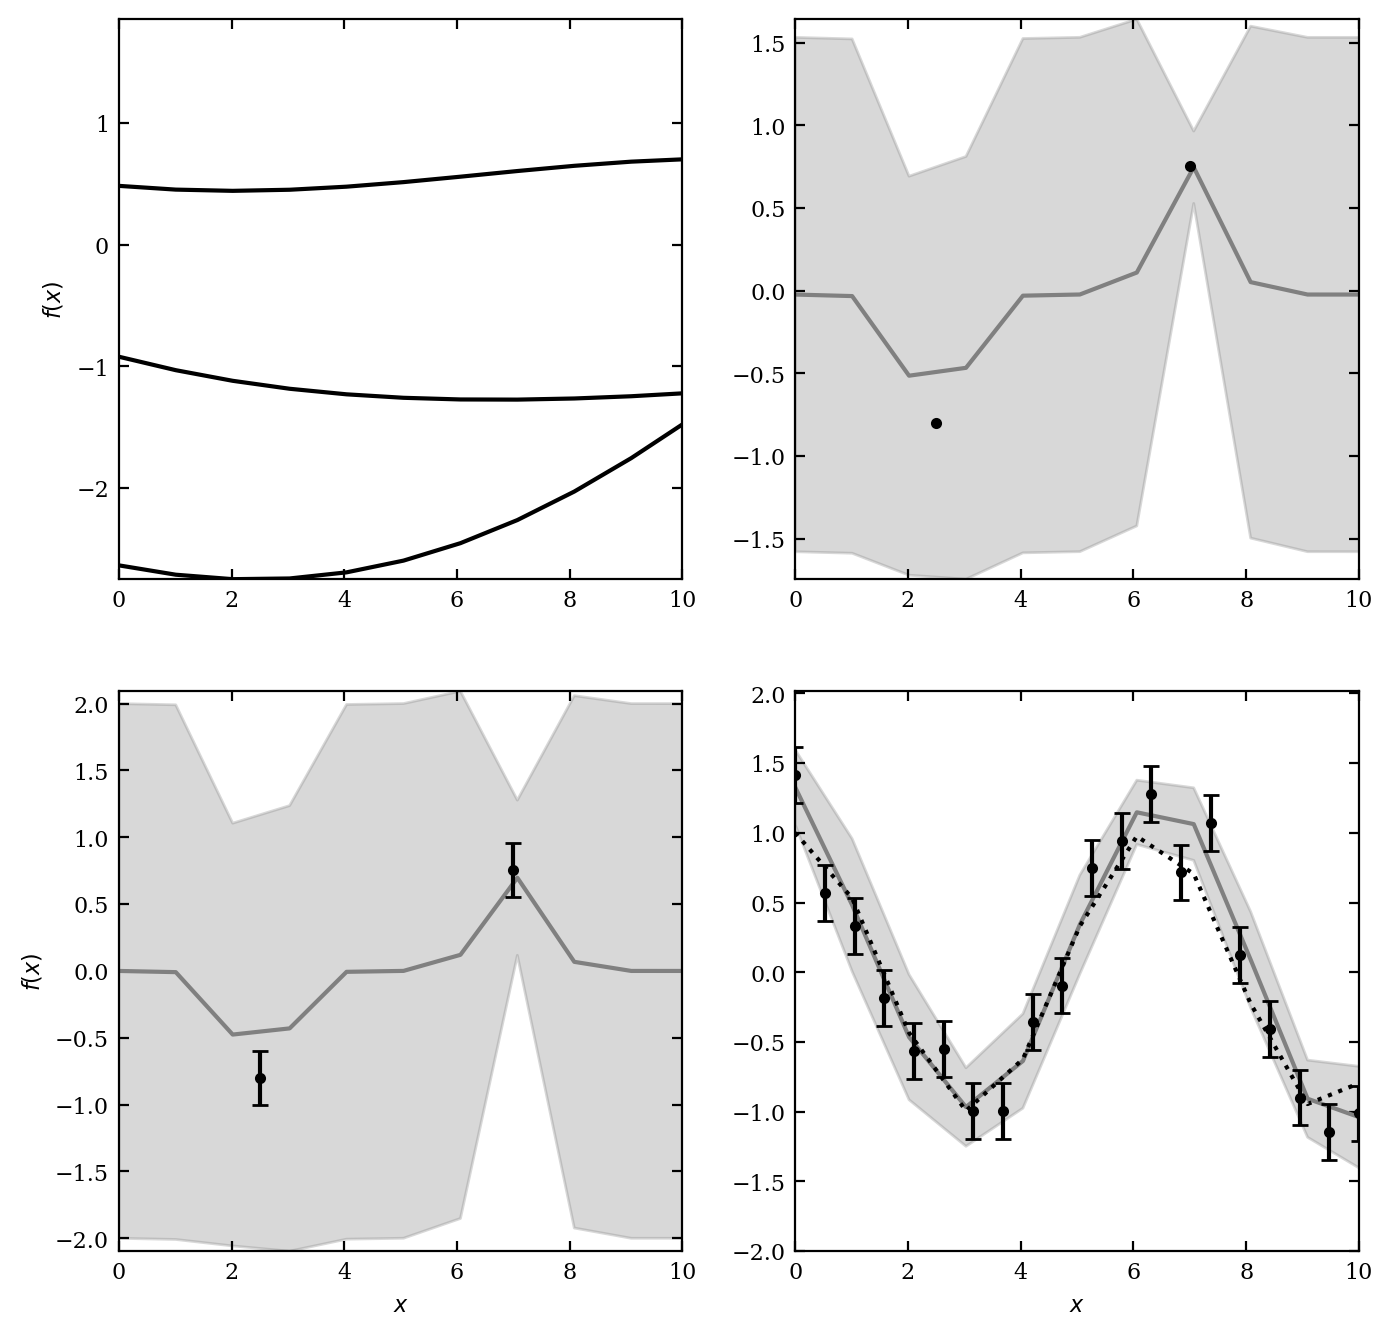

In [36]:
# Ivezic v2, Figure 8.10
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
#from scipy.optimize import fmin_cobyla

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 100, 100) #This sets the number of Gaussians
h = 10.0  #This is the Bandwidth

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7.0])
y1 = np.cos(x1)
kernel1 = kernels.RBF(0.5, (0.01, 10.0))
gp1 = GaussianProcessRegressor(kernel=kernel1,
                               random_state=0, normalize_y=True)
gp1.fit(x1[:, None], y1)
f1, f1_err = gp1.predict(x[:, None], 
                         return_std=True)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget (alpha parameter)" can be specified.
#  The diagonal of the assumed covariance matrix is multiplied by the nugget.
#  This is how the error on inputs is incorporated into the calculation.
dy2 = 0.2
kernel2 = kernels.RBF(0.5, (0.01, 10.0)) #kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp2 = GaussianProcessRegressor(kernel=kernel2,
                               alpha=(dy2 / y1) ** 2, 
                               random_state=0)
gp2.fit(x1[:, None], y1)
f2, f2_err = gp2.predict(x[:, None], 
                         return_std=True)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)

kernel3 = kernels.RBF(0.5, (0.01, 10.0))
gp3 = GaussianProcessRegressor(kernel=kernel3,
                               alpha=(dy3 / y3) ** 2, 
                               random_state=0)
gp3.fit(x3[:, None], y3)
f3, f3_err = gp3.predict(x[:, None], 
                         return_std=True)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp3.kernel_.theta[0])


#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(8, 8))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, 
                color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, 
                color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, 
                color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

<font color="blue"> Changing the number of gaussians affects the "peakyness" of the resulting confidence band. Changing the bandwitdth is a proportional procedure. </font>

For GP regression we want to estimate the value and variance of a new set of points given an input data set. **This is equivalent to averaging over all functions that pass through our input data**.

We compute the covariance matrix of all observed data and the new set of points that we want to predict:

$$  K = \begin{pmatrix}
    K_{11} & K_{12} \\
    K_{12}^T & K_{22}
  \end{pmatrix},
$$

where 
- $K_{11}$ is the covariance between the input points $x_i$ with observational errors $\sigma_i^2$ added in quadrature to the diagonal, 
- $K_{12}$ is the cross-covariance between the input points $x_i$ and the unknown points $x^\ast_j$,
- $K_{22}$ is the covariance between the unknown points $x_j^\ast$.  

For observed vectors $\vec{x}$ and $\vec{y}$, and a vector of unknown points $\vec{x}^\ast$, it can be shown that the posterior is given by (see the Rasmussen & Williams text above)

$$  p(f_j | \{x_i, y_i, \sigma_i\}, x_j^\ast) = \mathcal{N}(\vec{\mu}, \Sigma) $$

where

$$
\begin{eqnarray}
  \vec{\mu} &=& K_{12} K_{11}^{-1} \vec{y}, \\
  \Sigma &=& K_{22} - K_{12}^TK_{11}^{-1}K_{12}
\end{eqnarray}
$$

$\mu_j$ gives the expected value $\bar{f}^\ast_j$ of the predicted result, and $\Sigma_{jk}$ gives the error covariance between any two unknown points (which measures the prediction uncertainty).

**This is key: it gives the mean AND uncertainty of a predicted point.**

Note that the physics of the underlying process enters through the assumed form of the covariance function, which has a variety of choices-- again see the [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/). 

The Scikit-Learn [`GaussianProcess`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) implementation looks like:

In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor

X = np.random.random((100,2))
y = np.sin(10*X[:,0] + X[:,1])
gp = GaussianProcessRegressor()
gp.fit(X,y)
y_pred, dy_pred = gp.predict(X, return_std=True)
#print(y_pred, dy_pred)

Below we'll see what GPR does for the supernova example that we used last time. What is great is that not only do you get a fit, you get errors and can tell where the fit is good and where it is poor. Clearly, as expected, the prediction gets successively poor as we move beyond the range of the training data.

*Gaussian Processes are also pretty useful for time-domain data too, so may come back to them again.*

/home/js3/miniconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


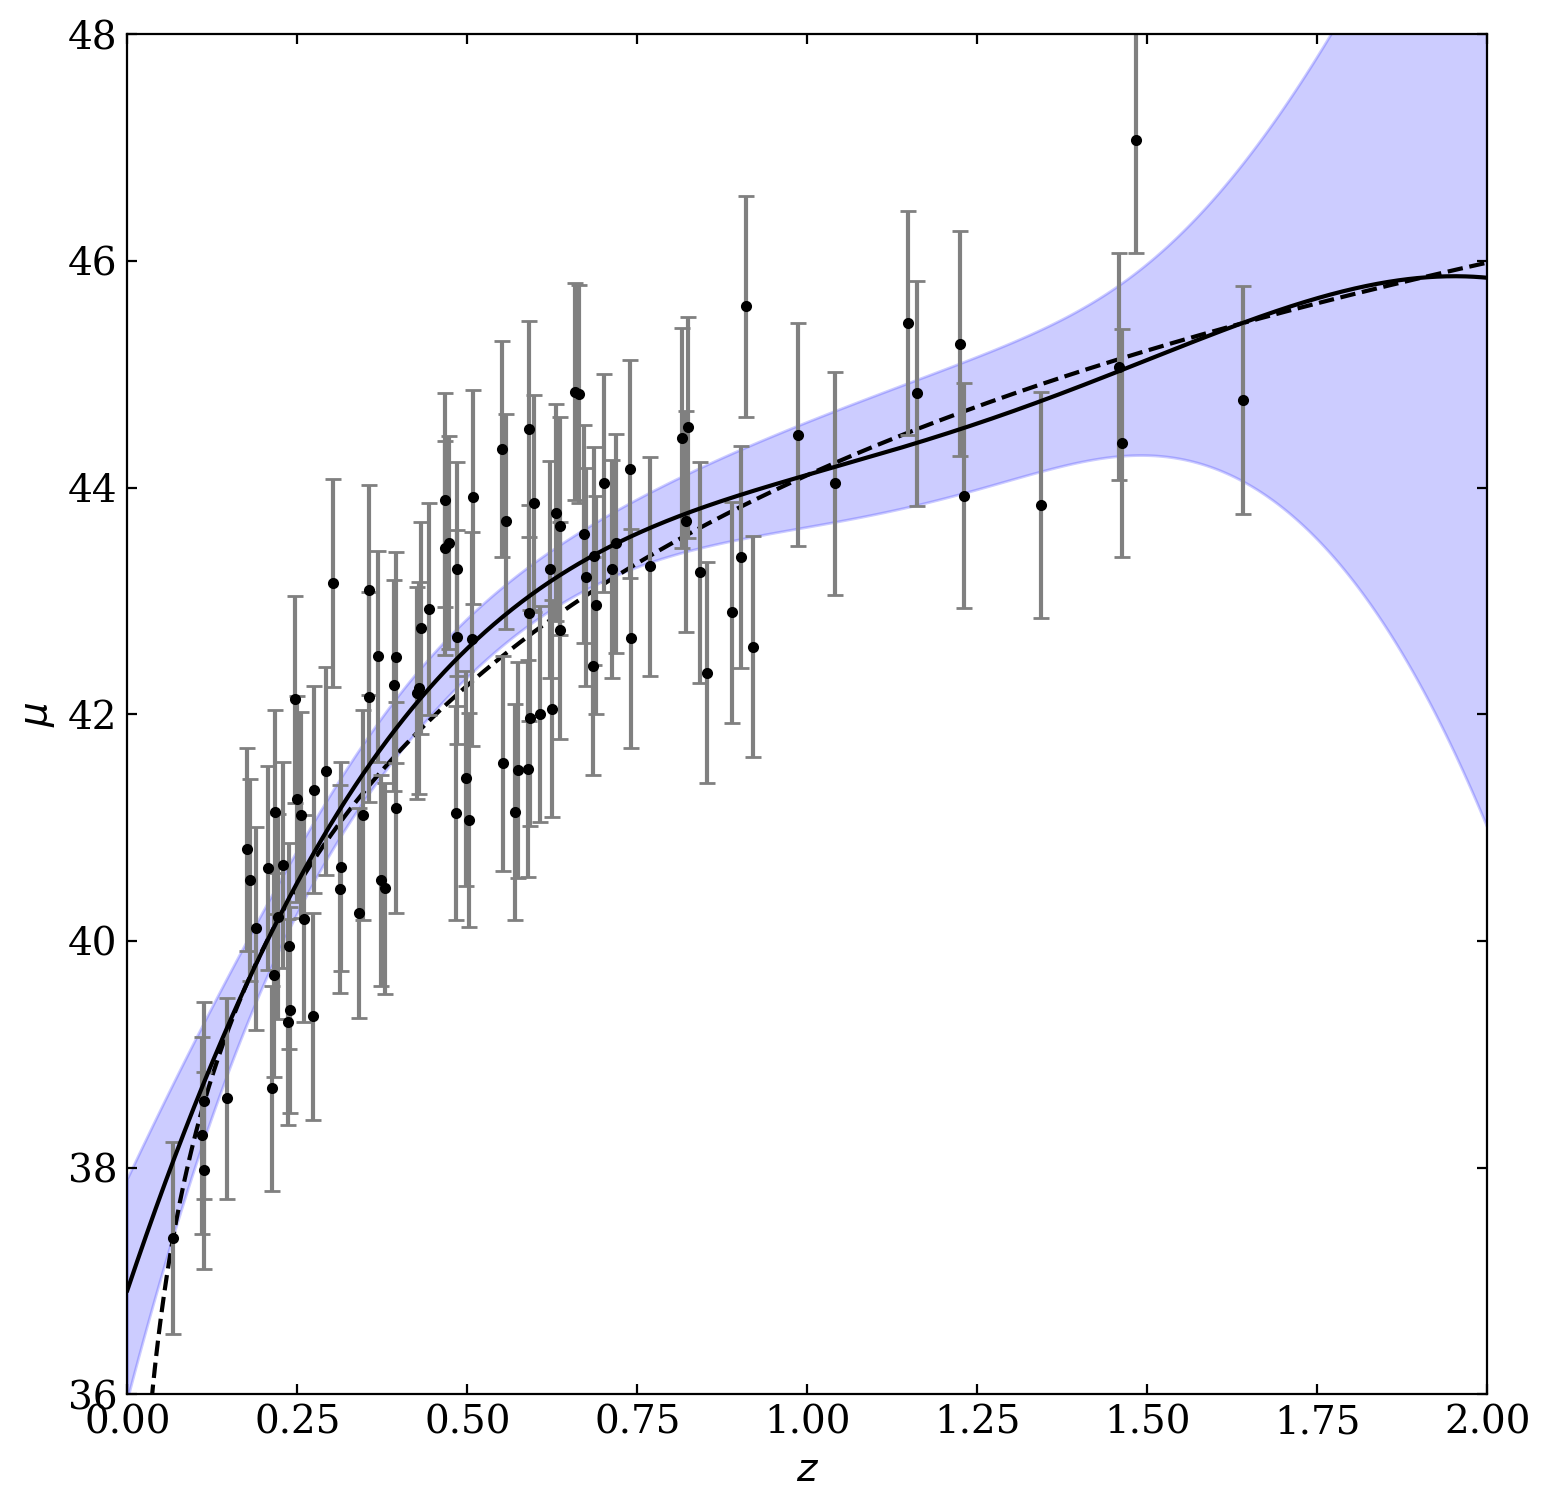

In [32]:
# Ivezic v2, Figure 8.11
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=False)

# ------------------------------------------------------------
# Generate data
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73, Tcmb0=0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0, 
                                         cosmo=cosmo)

z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# ------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)
y_pred, sigma = gp.predict(z_fit[:, None], 
                           return_std=True)

# ------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.95, 
                    bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
            ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, 
                y_pred + 1.96 * sigma,
                alpha=0.2, color='b', 
                label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()

## Uncertainties All Round <a class="anchor" id="four"></a>

What about real-world applications, where the **independent variable, $x$, (usually) is not free from any uncertainty**? Imagine the "true" relation,

$$ y^*_i=\theta_0 + \theta_1x^*_{i}. $$

Now we make measurements in $x$, and $y$ which are noisy (Gaussian noise)

$$
x_i = x^*_i + \delta_i,\\
y_i = y^* + \epsilon_i,
$$

Solving for $y$ we get
$$
      \hat{y}_i=  \theta_0 + \theta_1 (x_i - \delta_i) +\epsilon_i.
$$

Thus $\hat{y}$ depends on the noise in $x$, such that the uncertainty in $x$ is now part of the regression equation and scales with the regression coefficients. 

This problem is known as **Total Least Squares (TLS)**. In TLS, we build a likelihood that measures the **perpendicular distance of points from a modeled line**, rather than what we have done thus far in ordinary least squares (OLS) which measures only the **vertical distance of $y$ data values from the modeled curve**. Image credit: [here](https://towardsdatascience.com/total-least-squares-in-comparison-with-ols-and-odr-f050ffc1a86a).

![](https://miro.medium.com/max/854/1*illoIj5LRD3NrQ69iV30kw.png)

How can we account for the measurement uncertainties in both the independent and dependent variables? Assuming they are Gaussian, the total data covariance matrix is

$$ \Sigma_i = \left[
\begin{array}{cc}
\sigma_{x_i}^2 & \sigma_{xy_i} \\
\sigma_{xy_i} & \sigma_{y_i}^2
\end{array}
\right].
$$

We'll consider straight-line regression. **It will help us to think of our line geometrically, where we define it in terms of its normal vector**:

$$ {\bf n} = \left [
\begin{array}{c}
-\sin \alpha\\
\cos \alpha\\
\end{array}
\right ] 
$$

with $\theta_1 = \arctan(\alpha)$ and $\alpha$ is the angle between the line and the $x$-axis. 

The covariance matrix projects onto this space as

$$ S_i^2 = {\bf n}^T \Sigma_i {\bf n} $$

and the  distance between a point and the line is

$$\Delta_i = {\bf n}^T z_i - \theta_0\ \cos \alpha, $$
  
where $z_i$ represents the data point $(x_i,y_i)$. You may need to think and sketch out the latter equation. The first part makes sense since it is just projecting the coordinate vector onto the line's normal vector. The second part subtracts off the excess of this projection in case the line is vertically offset from zero-intercept. 

The log-likelihood is then

$$ \ln\mathcal{L} \propto - \sum_i \frac{\Delta_i^2}{2 S_i^2}$$

and we can maximize the likelihood as a brute-force search or through MCMC. 

In the following code cell, data has uncertainties in $x$ and $y$, and a straight line is numerically fit through **Total Least Squares**. The resulting measured parameter uncertainty regions for the intercept and slope are shown in the right panel.

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


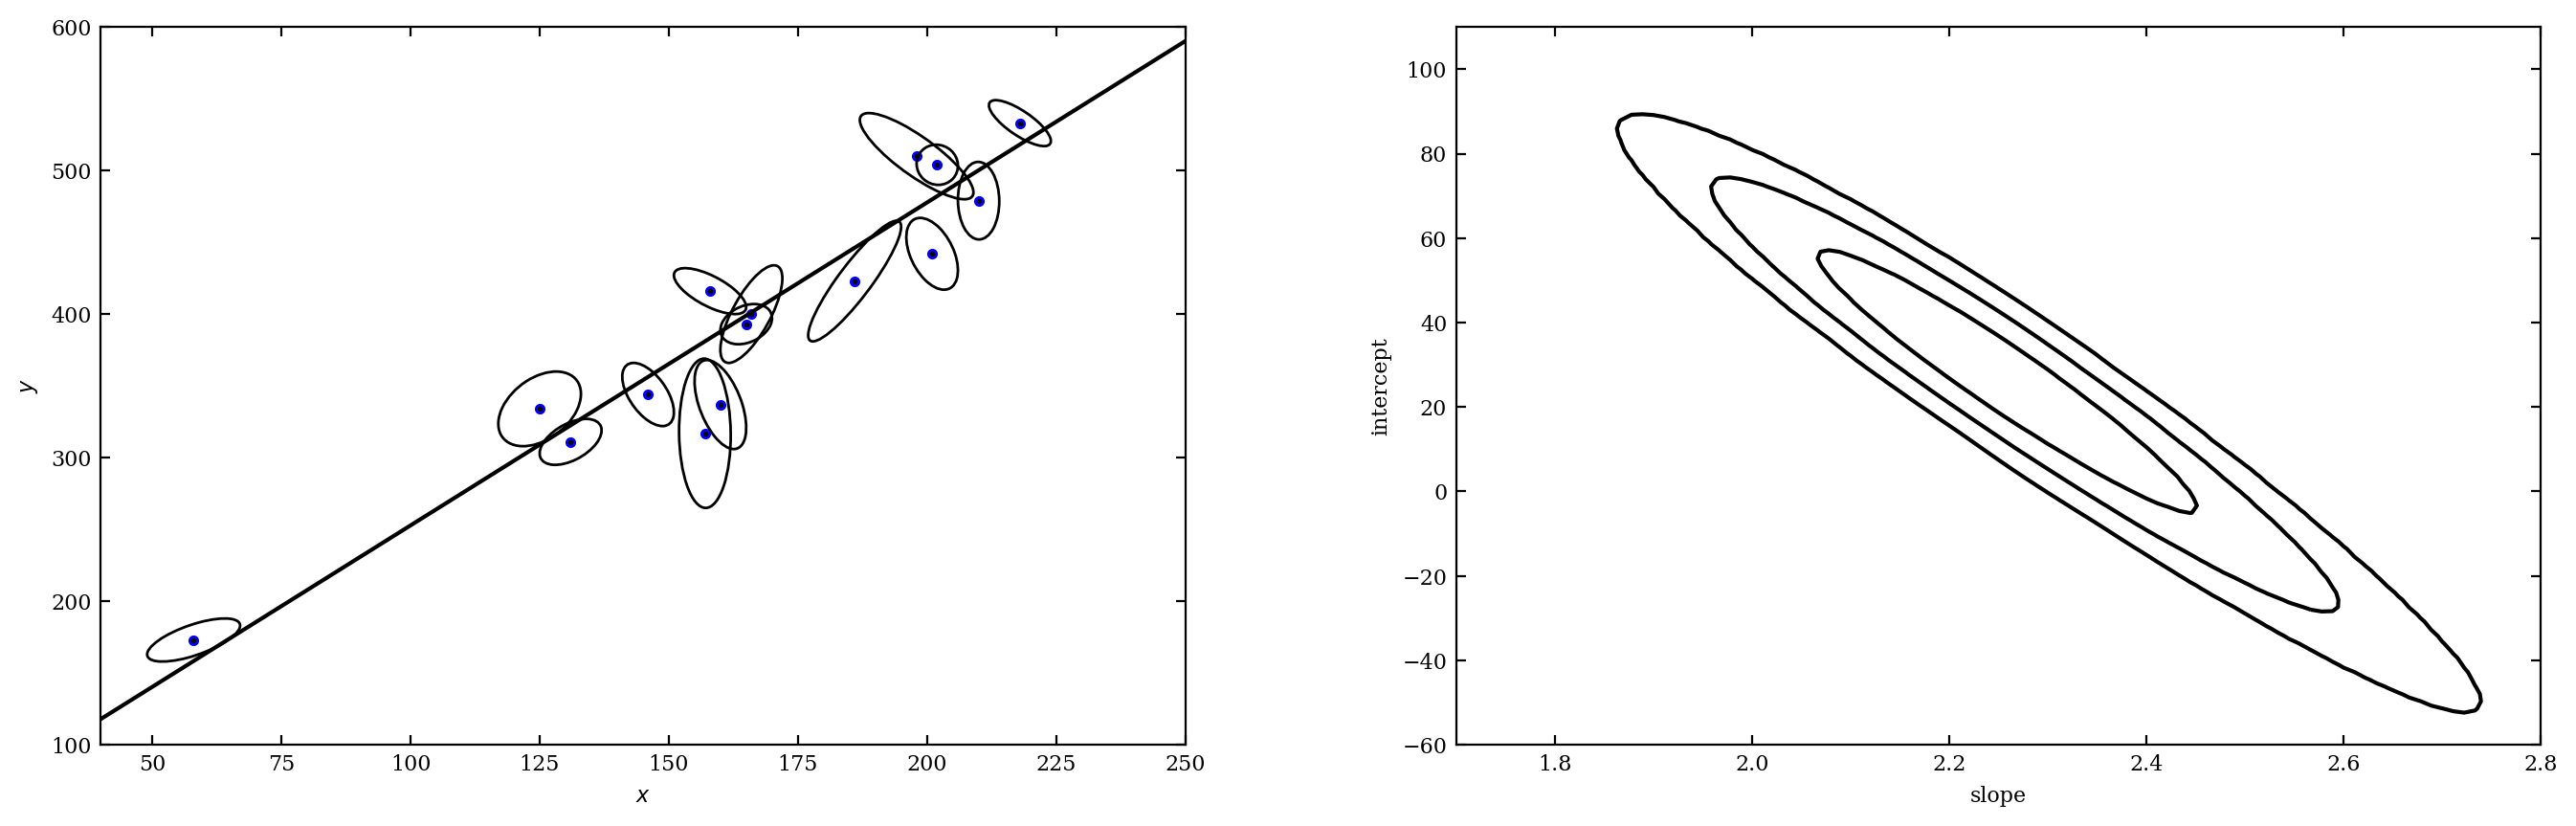

In [33]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy import optimize
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, 
                  rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, 
                                          sigma_y, 
                                          rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse(xy=(x[i], y[i]),
                             width=factor * sigma1[i], height=factor * sigma2[i],
                             angle=alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))

#------------------------------------------------------------
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

#------------------------------------------------------------
# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 1])

#------------------------------------------------------------
# Plot the data and fits
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

#------------------------------------------------------------
# first let's visualize the data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

#------------------------------------------------------------
# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit = np.linspace(0, 300, 10)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

#------------------------------------------------------------
# plot the likelihood contour in m, b
ax = fig.add_subplot(122)
m = np.linspace(1.7, 2.8, 100)
b = np.linspace(-60, 110, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_xlim(1.7, 2.8)
ax.set_ylim(-60, 110)

plt.show()